In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import tensorflow as tf

In [31]:
from google.colab import files

In [32]:
uploaded=files.upload()

Saving currency_exchange_rates_02-01-1995_-_02-05-2018.csv to currency_exchange_rates_02-01-1995_-_02-05-2018.csv


In [33]:
df = pd.read_csv('currency_exchange_rates_02-01-1995_-_02-05-2018.csv')

In [34]:
df

,Date,Algerian Dinar,Australian Dollar,Bahrain Dinar,Bolivar Fuerte,Botswana Pula,Brazilian Real,Brunei Dollar,Canadian Dollar,Chilean Peso,Chinese Yuan,Colombian Peso,Czech Koruna,Danish Krone,Euro,Hungarian Forint,Icelandic Krona,Indian Rupee,Indonesian Rupiah,Iranian Rial,Israeli New Sheqel,Japanese Yen,Kazakhstani Tenge,Korean Won,Kuwaiti Dinar,Libyan Dinar,Malaysian Ringgit,Mauritian Rupee,Mexican Peso,Nepalese Rupee,New Zealand Dollar,Norwegian Krone,Nuevo Sol,Pakistani Rupee,Peso Uruguayo,Philippine Peso,Polish Zloty,Qatar Riyal,Rial Omani,Russian Ruble,Saudi Arabian Riyal,Singapore Dollar,South African Rand,Sri Lanka Rupee,Swedish Krona,Swiss Franc,Thai Baht,Trinidad And Tobago Dollar,Tunisian Dinar,U.A.E. Dirham,U.K. Pound Sterling,U.S. Dollar
0,1995-1-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,1995-1-3,NaN,NaN,0.376,NaN,NaN,0.8430,NaN,1.4035,NaN,NaN,833.18,NaN,6.1185,NaN,NaN,68.56,31.3700,2201.0,1753.998616,NaN,NaN,NaN,788.7,0.29964,0.5250,2.5525,NaN,NaN,49.88,NaN,6.7990,NaN,30.8770,NaN,NaN,NaN,3.64,0.3845,NaN,3.745,1.4563,3.55000,50.0400,7.4588,1.3168,25.100,5.8750,NaN,3.6710,1.56170,1.0
2,1995-1-4,NaN,0.7704,0.376,NaN,NaN,0.8440,NaN,1.4026,NaN,NaN,835.38,NaN,6.1240,NaN,NaN,68.66,31.3700,2202.0,1753.525647,NaN,100.98,NaN,788.5,0.29982,0.5250,2.5510,NaN,NaN,49.88,0.6401,6.8040,NaN,30.8770,NaN,NaN,NaN,3.64,0.3845,NaN,3.745,1.4537,3.56000,50.0700,7.4480,1.3161,25.130,5.8738,NaN,3.6710,1.56050,1.0
3,1995-1-5,NaN,0.7693,0.376,NaN,NaN,0.8440,NaN,1.4002,NaN,NaN,838.33,NaN,6.1135,NaN,NaN,68.56,31.3700,2202.0,1746.890000,NaN,101.00,NaN,789.3,0.29982,0.5250,2.5488,NaN,NaN,49.88,0.6381,6.7885,NaN,30.8770,NaN,NaN,NaN,3.64,0.3845,NaN,3.745,1.4520,3.55000,50.0700,7.4450,1.3080,25.140,5.8700,NaN,3.6710,1.56100,1.0
4,1995-1-6,NaN,0.7699,0.376,NaN,NaN,0.8420,NaN,1.4002,NaN,NaN,838.87,NaN,6.0965,NaN,NaN,68.43,31.3700,2202.0,1744.746721,NaN,100.95,NaN,789.6,NaN,0.5250,2.5497,NaN,NaN,49.88,0.6387,6.7680,NaN,30.8770,NaN,NaN,NaN,3.64,0.3845,NaN,3.745,1.4527,3.56000,50.0700,NaN,1.3040,25.130,5.8810,NaN,3.6710,1.56450,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,2018-4-26,114.8506,0.7574,0.376,66770.1562,0.1023,3.4971,1.3274,1.2862,603.31,6.3352,2820.29,20.944,6.1234,1.2168,257.42,101.00,66.8299,13930.0,42000.000000,3.579,109.37,327.92,1078.7,0.30065,1.9324,3.9205,34.05450,18.8644,107.05,0.7069,7.9500,3.235,115.6175,28.412,52.287,3.4827,3.64,0.3845,62.6027,3.750,1.3274,12.40640,157.4628,8.5481,0.9835,31.595,6.7842,2.42955,3.6725,1.39655,1.0
5974,2018-4-27,115.0604,0.7545,0.376,66770.1562,0.1020,3.4670,1.3269,NaN,603.31,6.3407,2812.83,21.102,NaN,1.2070,258.96,101.40,66.7801,13879.0,NaN,3.597,109.31,327.72,1079.7,0.30065,1.9324,3.9195,34.14510,18.6847,106.81,0.7064,8.0025,NaN,115.6137,NaN,52.231,3.5003,3.64,0.3845,62.7260,3.750,1.3269,NaN,157.6459,8.6911,0.9907,31.617,6.7572,2.43120,3.6725,1.37685,1.0
5975,2018-4-30,114.8873,0.7570,0.376,68827.5000,0.1023,3.4805,1.3238,1.2836,605.74,6.3407,2806.28,21.144,6.1678,1.2079,258.96,101.03,66.7801,13877.0,41811.000000,3.588,109.31,327.25,1076.2,0.30080,1.9324,3.9195,34.18045,18.7878,106.66,0.7079,7.9990,3.248,115.6075,28.596,51.965,3.4868,3.64,0.3845,61.9997,3.750,1.3238,12.43145,157.6459,8.6774,0.9894,31.510,6.7393,2.43190,3.6725,1.37250,1.0
5976,2018-5-1,NaN,0.7540,0.376,NaN,NaN,NaN,NaN,NaN,610.98,NaN,2809.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42000.000000,3.616,109.30,NaN,NaN,0.30100,1.9324,NaN,NaN,NaN,106.66,0.7033,NaN,NaN,NaN,NaN,NaN,NaN,3.64,0.3845,NaN,3.750,NaN,NaN,157.4737,NaN,NaN,NaN,6.7385,NaN,3.6725,1.36945,1.0


In [38]:
df = df[['Date', 'Indonesian Rupiah']]
df = df.iloc[::-1]
df

,Date,Indonesian Rupiah
5977,2018-5-2,NaN
5976,2018-5-1,NaN
5975,2018-4-30,13877.0
5974,2018-4-27,13879.0
5973,2018-4-26,13930.0
...,...,...
4,1995-1-6,2202.0
3,1995-1-5,2202.0
2,1995-1-4,2202.0
1,1995-1-3,2201.0


In [40]:
df.isnull().sum()

Date                    0
Indonesian Rupiah    1492
dtype: int64

In [41]:
df.dropna(subset = ["Indonesian Rupiah"], inplace=True)

In [42]:
df

,Date,Indonesian Rupiah
5975,2018-4-30,13877.0
5974,2018-4-27,13879.0
5973,2018-4-26,13930.0
5972,2018-4-25,13888.0
5971,2018-4-24,13900.0
...,...,...
5,1995-1-9,2203.0
4,1995-1-6,2202.0
3,1995-1-5,2202.0
2,1995-1-4,2202.0


In [43]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [44]:
df.set_index('Date', inplace=True)
df = df.astype(float)

In [45]:
df

,Indonesian Rupiah
Date,
2018-04-30,13877.0
2018-04-27,13879.0
2018-04-26,13930.0
2018-04-25,13888.0
2018-04-24,13900.0
...,...
1995-01-09,2203.0
1995-01-06,2202.0
1995-01-05,2202.0


In [46]:
sequence_length = 20
n_features = len(df.columns)
val_ratio = 0.2
n_epochs = 200
batch_size = 100

In [47]:
data = df.values
data_processed = []
for index in range(len(data) - sequence_length):
    data_processed.append(data[index: index + sequence_length])
data_processed = np.array(data_processed)


In [48]:
val_split = round((1 - val_ratio) * data_processed.shape[0])
train = data_processed[: int(val_split), :]
val = data_processed[int(val_split):, :]

In [49]:
print('Training data: {}'.format(train.shape))
print('Validation data: {}'.format(val.shape))

Training data: (3573, 20, 1)
Validation data: (893, 20, 1)


In [50]:
train_samples, train_nx, train_ny = train.shape
val_samples, val_nx, val_ny = val.shape

In [51]:
train = train.reshape((train_samples, train_nx * train_ny))
val = val.reshape((val_samples, val_nx * val_ny))

In [52]:
preprocessor = MinMaxScaler().fit(train)
train = preprocessor.transform(train)
val = preprocessor.transform(val)

In [53]:
train = train.reshape((train_samples, train_nx, train_ny))
val = val.reshape((val_samples, val_nx, val_ny))

In [54]:
X_train = train[:, : -1]
y_train = train[:, -1][:, -1]
X_val = val[:, : -1]
y_val = val[:, -1][:, -1]

In [55]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], n_features))

In [56]:
model = Sequential()
model.add(LSTM(input_shape=(X_train.shape[1:]), units=128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=30))
model.add(Dropout(0.6))
model.add(Dense(units=1))
model.add(Activation("linear"))

In [57]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.10):
      print("\nmae telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [58]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [59]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=(X_val, y_val),
    callbacks=[callbacks],
    verbose=2)

Epoch 1/200
36/36 - 37s - loss: 0.1112 - mae: 0.3657 - val_loss: 0.3791 - val_mae: 0.7858
Epoch 2/200
36/36 - 5s - loss: 0.0829 - mae: 0.2892 - val_loss: 0.4182 - val_mae: 0.8113
Epoch 3/200
36/36 - 5s - loss: 0.0642 - mae: 0.2430 - val_loss: 0.4468 - val_mae: 0.8406
Epoch 4/200
36/36 - 5s - loss: 0.0532 - mae: 0.2257 - val_loss: 0.4669 - val_mae: 0.8658
Epoch 5/200
36/36 - 5s - loss: 0.0492 - mae: 0.2270 - val_loss: 0.4797 - val_mae: 0.8826
Epoch 6/200
36/36 - 5s - loss: 0.0454 - mae: 0.2248 - val_loss: 0.4884 - val_mae: 0.8947
Epoch 7/200
36/36 - 5s - loss: 0.0418 - mae: 0.2236 - val_loss: 0.4929 - val_mae: 0.9017
Epoch 8/200
36/36 - 5s - loss: 0.0407 - mae: 0.2261 - val_loss: 0.4941 - val_mae: 0.9048
Epoch 9/200
36/36 - 5s - loss: 0.0409 - mae: 0.2286 - val_loss: 0.4932 - val_mae: 0.9051
Epoch 10/200
36/36 - 5s - loss: 0.0395 - mae: 0.2249 - val_loss: 0.4909 - val_mae: 0.9037
Epoch 11/200
36/36 - 5s - loss: 0.0389 - mae: 0.2254 - val_loss: 0.4878 - val_mae: 0.9013
Epoch 12/200
36/36

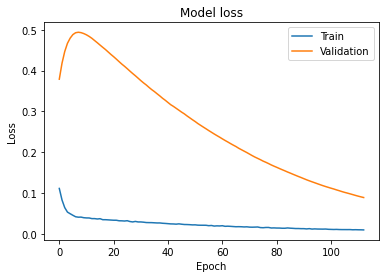

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

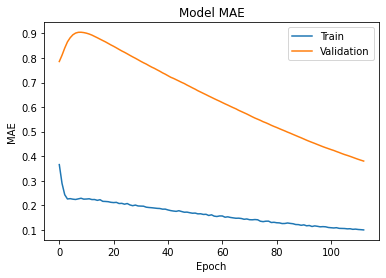

In [63]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()